# Import Libraries

In [3]:
import yfinance as yf
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from fracdiff.sklearn import FracdiffStat
import numpy as np

# Download data

In [4]:
aapl = yf.download('AAPL', start='2018-01-01', end='2024-01-01')

c:\Users\markm\miniconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [5]:
sp500 = yf.download('^GSPC', start='2018-01-01', end='2024-01-01')

# Align AAPL data with S&P 500 data
aapl['SP500'] = sp500['Close'].reindex(aapl.index).fillna(method='ffill')
aapl['SP500_diff'] = aapl['SP500'].diff()


c:\Users\markm\miniconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\markm\AppData\Local\Temp\ipykernel_16372\859413952.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl['SP500'] = sp500['Close'].reindex(aapl.index).fillna(method='ffill')


# Adding Technnical Indicators

In [6]:
aapl = add_all_ta_features(
    aapl, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

c:\Users\markm\miniconda3\lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


# Data Labelling

In [7]:
aapl["Tomorrow"] = aapl["Close"].shift(-1)
aapl['diff'] = aapl['Close'].diff()
aapl["Target"] = (aapl["Tomorrow"]> aapl["Close"]).astype(int)

In [8]:
aapl.dropna(inplace=True)

In [9]:
labels = aapl['Target'].tolist()
aapl.drop(columns="Target",inplace=True)
aapl.drop(columns="Tomorrow",inplace=True)

# Data Preprocessing

In [10]:
# Initialize the Fracdiff object
f = FracdiffStat()

"""# Apply fractional differencing to the 'Close' price
aapl['Close_fdiff'] = fd.fit_transform(aapl[['Close']].values)"""

"# Apply fractional differencing to the 'Close' price\naapl['Close_fdiff'] = fd.fit_transform(aapl[['Close']].values)"

In [11]:
for indicator in aapl.columns:
    prob = adfuller(aapl[indicator])[1]
    print(indicator, prob)
    if prob > 0.05 and indicator != "Tomorrow" and indicator != "Target":
        newindicator = indicator + '_fdiff'
        aapl[newindicator] = f.fit_transform(aapl[[indicator]].values)
        aapl.drop(columns=indicator, inplace=True)
    

Open 0.9031146934850128
High 0.8819919913385899
Low 0.8941557715435576
Close 0.8868910233529375
Adj Close 0.8941706501138765
Volume 8.814358643062011e-05
SP500 0.8220988373972749
SP500_diff 3.8659447435113167e-22
volume_adi 0.9235044494164444
volume_obv 0.25546988153630823
volume_cmf 1.696241636223005e-05
volume_fi 8.323694361086767e-13
volume_em 2.850350091065007e-28
volume_sma_em 2.8336117130452147e-11
volume_vpt 0.617553302477007
volume_vwap 0.8823981082427111
volume_mfi 4.1867604280905835e-10
volume_nvi 0.9498315577589561
volatility_bbm 0.8921837919748895
volatility_bbh 0.8617237653279903
volatility_bbl 0.9307930096399348
volatility_bbw 2.0237701422763103e-05
volatility_bbp 4.4148754515192756e-16
volatility_bbhi 0.0
volatility_bbli 5.598644600504299e-24
volatility_kcc 0.8693652328404542
volatility_kch 0.8703669013429307
volatility_kcl 0.8803006431424724
volatility_kcw 0.0012552412349307216
volatility_kcp 4.802414974973168e-15
volatility_kchi 1.7213487674679685e-27
volatility_kcli 1

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(aapl)

# Creating Sequences for LSTM

In [13]:
sequence_length = 60

# Function to create sequences
def create_sequences(data, labels, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = labels[i+seq_length]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

In [14]:
X_all, y_all = create_sequences(aapl, labels, sequence_length)

# Calculate the index for the split, for example 80% for training
split_idx = int(len(X_all) * 0.95)

# Split the data into training and test sets
X_train = X_all[:split_idx]
y_train = y_all[:split_idx]
X_test = X_all[split_idx:]
y_test = y_all[split_idx:]

# DataLoader for LSTM 

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Create the dataset
traindataset = StockDataset(X_train_tensor, y_train_tensor)

# Create the DataLoader
trainLoader = DataLoader(traindataset, batch_size=32, shuffle=False)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create the dataset
testdataset = StockDataset(X_test_tensor, y_test_tensor)

# Create the DataLoader
testLoader = DataLoader(testdataset, batch_size=32, shuffle=False)

# LSTM Model Training

In [17]:
import torch.nn as nn

class StockPredictor(nn.Module):
    def __init__(self, num_features, hidden_units, num_layers):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(num_features, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)

# Define the model
num_features = X_train.shape[-1]  # Number of features
hidden_units = 200  # Number of hidden units
num_layers = 2  # Number of LSTM layers



In [18]:
model = StockPredictor(num_features, hidden_units, num_layers)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

minLossModel = StockPredictor(num_features, hidden_units, num_layers)
# Training loop
num_epochs = 150
min_loss = 1
epochLoss = []
for epoch in range(num_epochs):
    for features, labels in trainLoader:
        # Forward pass
        predictions = model(features).squeeze()
        loss = criterion(predictions, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epochLoss.append(loss.item())
    if loss.item() < min_loss:
        min_loss = loss.item()
        minLossModel = model

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}')



Epoch [10/150], Loss: 0.6578, minimum Loss: 0.6578
Epoch [20/150], Loss: 0.5716, minimum Loss: 0.5716
Epoch [30/150], Loss: 0.5371, minimum Loss: 0.5304
Epoch [40/150], Loss: 0.4969, minimum Loss: 0.4936
Epoch [50/150], Loss: 0.4916, minimum Loss: 0.4809
Epoch [60/150], Loss: 0.4451, minimum Loss: 0.4451
Epoch [70/150], Loss: 0.4241, minimum Loss: 0.4177
Epoch [80/150], Loss: 0.4059, minimum Loss: 0.3847
Epoch [90/150], Loss: 0.3530, minimum Loss: 0.3474
Epoch [100/150], Loss: 0.3258, minimum Loss: 0.3258
Epoch [110/150], Loss: 0.3151, minimum Loss: 0.2951
Epoch [120/150], Loss: 0.2400, minimum Loss: 0.2400
Epoch [130/150], Loss: 0.2250, minimum Loss: 0.2114
Epoch [140/150], Loss: 0.2543, minimum Loss: 0.1582
Epoch [150/150], Loss: 0.1566, minimum Loss: 0.1264


In [16]:
## Extra epochs
"""
num_epochs = 20
for epoch in range(num_epochs):
    for features, labels in trainLoader:
        # Forward pass
        predictions = model(features).squeeze()
        loss = criterion(predictions, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epochLoss.append(loss.item())
    if loss.item() < min_loss:
        min_loss = loss.item()
        minLossModel = model

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}')

"""

"\nnum_epochs = 20\nfor epoch in range(num_epochs):\n    for features, labels in trainLoader:\n        # Forward pass\n        predictions = model(features).squeeze()\n        loss = criterion(predictions, labels)\n\n        # Backward pass and optimization\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    epochLoss.append(loss.item())\n    if loss.item() < min_loss:\n        min_loss = loss.item()\n        minLossModel = model\n\n    if (epoch+1) % 10 == 0:\n        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}')\n\n"

# Evaluation

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

minLossModel.eval()  # Set the minLossModel to evaluation mode

# Store predictions and actuals
predictions = []
actuals = []

with torch.no_grad():  # No need to track the gradients
    for features, labels in testLoader:
        # Forward pass to get output/prediction
        outputs = minLossModel(features).squeeze()

        # Since we're using sigmoid, we will round the outputs to get the binary class
        predicted_classes = torch.round(outputs)
        
        if predicted_classes.ndim == 0:
            predicted_classes = predicted_classes.unsqueeze(0)

        # Store predictions and actual labels
        predictions.extend(predicted_classes.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for evaluation
predictions_array = np.array(predictions)
actuals_array = np.array(actuals)

# Calculate various classification metrics
accuracy = accuracy_score(actuals_array, predictions_array)
precision = precision_score(actuals_array, predictions_array)
recall = recall_score(actuals_array, predictions_array)
f1 = f1_score(actuals_array, predictions_array)
conf_matrix = confusion_matrix(actuals_array, predictions_array)

# Print out the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.5068
Precision: 0.5532
Recall: 0.6341
F1 Score: 0.5909
Confusion Matrix:
[[11 21]
 [15 26]]


In [38]:
#length of array    
predictions_array


AttributeError: 'numpy.ndarray' object has no attribute 'length'

In [23]:
predictions_array30 = predictions_array[:30]
actuals_array30 = actuals_array[:30]

# Calculate various classification metrics
accuracy = accuracy_score(actuals_array30, predictions_array30)
precision = precision_score(actuals_array30, predictions_array30)
recall = recall_score(actuals_array30, predictions_array30)
f1 = f1_score(actuals_array30, predictions_array30)
conf_matrix = confusion_matrix(actuals_array30, predictions_array30)

# Print out the metrics
print("Evaluation for the  first 30 samples:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Evaluation for the  first 30 samples:
Accuracy: 0.5667
Precision: 0.5652
Recall: 0.8125
F1 Score: 0.6667
Confusion Matrix:
[[ 4 10]
 [ 3 13]]


# Loss Curve

Text(0.5, 1.0, 'loss curve')

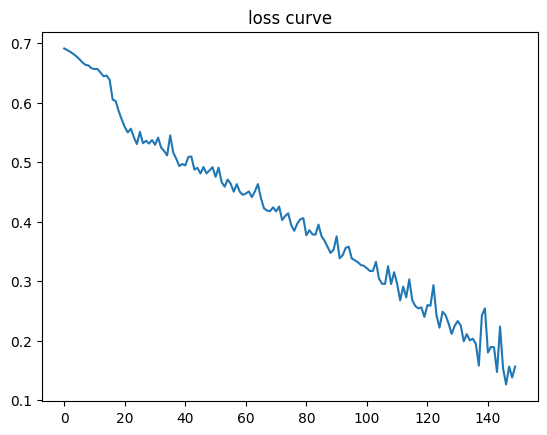

In [29]:
plt.plot(epochLoss)
plt.title("loss curve")

In [42]:
# Download AAPL closing prices
aapl_closing = yf.download('AAPL', start='2018-01-01', end='2024-01-01')["Close"]

# Focus on the last 5% of the period
last_five_percent = aapl_closing.tail(int(len(aapl_closing) * 0.05))
last_five_percent = last_five_percent.iloc[:-1]

# Calculate daily returns for the last 5%
actuals_daily_returns = np.diff(last_five_percent.values) / last_five_percent.values[:-1]

# Ensure 'signals' is aligned in size with 'actuals_daily_returns'
# This might involve slicing 'predictions_array' to match the exact period of 'last_five_percent'
signals = predictions_array[-len(actuals_daily_returns):]  # Adjust this line as necessary

# Calculate strategy daily returns
strategy_daily_returns = signals * actuals_daily_returns

# Calculate performance metrics
cumulative_return = np.prod(strategy_daily_returns + 1) - 1
negative_returns = strategy_daily_returns[strategy_daily_returns < 0]
downside_deviation = np.sqrt(np.mean(negative_returns ** 2))
expected_return = np.mean(strategy_daily_returns)
risk_free_rate = 0  # Adjust as necessary
sortino_ratio = (expected_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan

# Display Performance Metrics
print("\nTrading Strategy Performance:")
print(f"Cumulative Return: {cumulative_return * 100:.2f}%")
print(f"Downside Deviation: {downside_deviation:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")

c:\Users\markm\miniconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Trading Strategy Performance:
Cumulative Return: 7.42%
Downside Deviation: 0.0097
Sortino Ratio: 0.1047
